
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
%matplotlib inline

import timeit

import warnings

plt.style.use('seaborn-white')

In [16]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

# Función Carga de BD

In [2]:
def carga_bd():
    
    global mx_bd
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_perforacion',
                                  'hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'asignacion'],
                             low_memory=False)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

In [3]:
carga_bd()

'Tiempo de procesamiento: 39.07014290000001 segundos'

# Función Productividad de pozos

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
%matplotlib inline

import timeit
import warnings

plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")


def productividad(hidrocarburo,baja,media,alta):
    
    global unique_well_list
    global perfil
    global df
    global estadistica
    global tipo1
    global tipo2
    global tipo3
    global ajuste
    
    tic=timeit.default_timer()
    
##################    AJUSTE DE DISTRIBUCION DE PROBABILIDAD   ######################
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                               'expon',
                               'gamma',
                               'lognorm',
                               'norm',
                               'pearson3',
                               'triang',
                               'uniform',
                               'weibull_min', 
                               'weibull_max',
                               'alpha',             
                               'anglit',            
                               'arcsine',           
                               'argus',          
                               'beta',              
                               'betaprime',         
                               'bradford',          
                               'burr',              
                               'burr12',            
                               'cauchy',            
                               'chi',               
                               'chi2',              
                               'cosine',            
                               'crystalball',       
                               'dgamma',            
                               'dweibull',          
                               'erlang',            
                               'expon',             
                               'exponnorm',         
                               'exponweib',         
                               'exponpow',          
                               'f',                 
                               'fatiguelife',       
                               'fisk',              
                               'foldcauchy',        
                               'foldnorm',          
                               'frechet_r',         
                               'frechet_l',         
                               'genlogistic',       
                               'gennorm',           
                               'genpareto',         
                               'genexpon',          
                               'genextreme',        
                               'gausshyper',        
                               'gamma',             
                               'gengamma',          
                               'genhalflogistic',   
                               'gilbrat',           
                               'gompertz',          
                               'gumbel_r',          
                               'gumbel_l',          
                               'halfcauchy',        
                               'halflogistic',      
                               'halfnorm',          
                               'halfgennorm',       
                               'hypsecant',         
                               'invgamma',          
                               'invgauss',          
                               'invweibull',        
                               'johnsonsb',         
                               'johnsonsu',         
                               'kappa4',            
                               'kappa3',            
                               'ksone',             
                               'kstwobign',         
                               'laplace',           
                               'levy',              
                               'levy_l',
                               'levy_stable',
                               'logistic',          
                               'loggamma',          
                               'loglaplace',        
                               'lognorm',           
                               'lomax',             
                               'maxwell',           
                               'mielke',            
                               'moyal',             
                               'nakagami',          
                               'ncx2',              
                               'ncf',               
                               'nct',               
                               'norm',              
                               'norminvgauss',      
                               'pareto',            
                               'pearson3',          
                               'powerlaw',          
                               'powerlognorm',      
                               'powernorm',         
                               'rdist',             
                               'reciprocal',        
                               'rayleigh',          
                               'rice',              
                               'recipinvgauss',     
                               'semicircular',      
                               'skewnorm',          
                               't',                 
                               'trapz',             
                               'triang',            
                               'truncexpon',        
                               'truncnorm',         
                               'tukeylambda',       
                               'uniform',           
                               'vonmises',          
                               'vonmises_line',     
                               'wald',              
                               'weibull_min',      
                               'weibull_max',       
                               'wrapcauchy']
            
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global campo
        global input_campo
    
        #Input de campo
        input_campo = input("Nombre de campo: ")

        seleccion=mx_bd.pozo.str.contains(str(input_campo))
        campo=mx_bd.loc[seleccion]

        unique_well_list=pd.unique(campo['pozo'])

        display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)))

        #Generacion de archivo de resultados
        #campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

        return campo
    

########      FUNCIONES PARA EL ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hiperbolica(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponencial(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonica(t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global base, resultados, gasto
        
        resultados=pd.DataFrame()
        fit=pd.DataFrame()
        gasto=pd.DataFrame()
        Qi=pd.DataFrame()
        base=pd.DataFrame()

        
        #Entrada de campo de análisis
        campo_analisis()
        data_pozos=campo
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #hidrocarburo de análisis
        hydrocarbon=str(hidrocarburo)
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hydrocarbon)
        
        #Get a list of unique wells to loop through
        unique_well_list=pd.unique(list(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        #Pull data that came online between an specified range
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2019-12-01')]
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset el data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hydrocarbon, 'fecha')
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
    
            #Exponential curve fit the data to get best fit equation
            #popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
             #                            serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hydrocarbon],bounds=(0, [qi,1,50]))
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            #serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
             #                     *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
                
            seleccion_base=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            
            fit=[[pozo,
                  popt_hyp[0],
                  popt_hyp[1],
                  popt_hyp[2],
                  perr_hyp[0],
                  perr_hyp[1],
                  popt_harm[0],
                  popt_harm[1],
                  perr_harm[0],
                  perr_harm[1],
                  seleccion_base[hidrocarburo],
                  (seleccion_base.mes)]]
    
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1]]]
    
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hydrocarbon,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hydrocarbon+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
    
            base=base.append(fit,sort=False)
            resultados=resultados.append(serie_produccion,sort=False)
            gasto=gasto.append(Qi,sort=True)
            
        base=base.rename(columns={0:'pozo',
                                  1:'Qi_hyp',
                                  2:'b',
                                  3:'di_hyp',
                                  4:'error_Qi_hyp',
                                  5:'error_di_hyp',
                                  6:'Qi_harm',
                                  7:'di_harm',
                                  8:'error_Qi_harm',
                                  9:'error_di_harm',
                                 10:hidrocarburo,
                                 11:'mes'})
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm'})
        
        estadistica=resultados.describe()
        
        #resultados.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
                
        return base, resultados, gasto
        
    analisis_dca()
    
#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    periodo=np.arange(start=1,stop=501,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=500,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    q_baja=gasto.Qi_hist.quantile(baja)
    q_media=gasto.Qi_hist.quantile(media)
    q_alta=gasto.Qi_hist.quantile(alta)
    
    #d_baja=gasto.di.quantile(baja)
    d_media=gasto.di_hyp.quantile(media)
    #d_media=gasto.di_harm.quantile(media)
    #d_alta=gasto.di.quantile(alta)
    
    d=gasto.di_hyp.mean()
    #d=gasto.di_harm.mean()
    b=gasto.b.mean()  

    criterio1=(gasto['Qi_hist'] <= q_baja)
    tipo1=gasto.loc[criterio1]
    

    #q_baja_1=tipo1.Qi_hist.quantile(baja)
    q_media_1=tipo1.Qi_hist.quantile(media)
    #q_alta_1=tipo1.Qi_hist.quantile(alta)
    
    #d_baja_1=tipo1.di.quantile(baja)
    d_media_1=tipo1.di_hyp.quantile(media)
    #d_media_1=tipo1.di_harm.quantile(media)
    #d_alta_1=tipo1.di.quantile(alta)
    
    d1=tipo1.di_hyp.mean()
    #d1=tipo1.di_harm.mean()
    b1=tipo1.b.mean()
    
    criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
    tipo2=gasto.loc[criterio2]
    
    
    #q_baja_2=tipo2.Qi_hist.quantile(baja)
    q_media_2=tipo2.Qi_hist.quantile(media)
    #q_alta_2=tipo2.Qi_hist.quantile(alta)
    
    #d_baja_2=tipo2.di.quantile(baja)
    d_media_2=tipo2.di_hyp.quantile(media)
    #d_media_2=tipo2.di_harm.quantile(media)
    #d_alta_2=tipo2.di.quantile(alta)
    
    d2=tipo2.di_hyp.mean()
    #d2=tipo2.di_harm.mean()
    b2=tipo2.b.mean()    
    
    criterio3=(gasto['Qi_hist'] >= q_alta)
    tipo3=gasto.loc[criterio3]
    
    #q_baja_3=tipo3.Qi_hist.quantile(baja)
    q_media_3=tipo3.Qi_hist.quantile(media)
    #q_alta_3=tipo3.Qi_hist.quantile(alta)
    
    #d_baja_3=tipo3.di.quantile(baja)
    d_media_3=tipo3.di_hyp.quantile(media)
    #d_media_3=tipo3.di_harm.quantile(media)
    #d_alta_3=tipo3.di.quantile(alta)
    
    d3=tipo3.di_hyp.mean()
    #d3=tipo3.di_harm.mean()
    b3=tipo3.b.mean()    
    
    perfil=pd.DataFrame()
    
    for x in df:
        
        perfil['mes']=df.periodo
        #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

        #perfil['P1_BAJA']=(q_baja_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        perfil['tipo1_baja']=(q_media_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        #perfil['P1_ALTA']=(q_alta_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))

        #perfil['P2_BAJA']=(q_baja_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        perfil['tipo2_media']=(q_media_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        #perfil['P2_ALTA']=(q_alta_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        
        #perfil['P3_BAJA']=(q_baja_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        perfil['tipo3_alta']=(q_media_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        #perfil['P3_ALTA']=(q_alta_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        
        #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

    d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
         'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
         'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
         'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
         'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
         'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
         'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
         'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
         'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
         'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()]}
    
    ajuste = pd.DataFrame(data=d,index=['Tipo1','Tipo2','Tipo3'])
    ajuste.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/parametros.csv')
        
    #perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
    perfil=perfil.set_index('mes')
    perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfiles_tipo.csv')
    
    display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
            'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
            'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
            'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

    display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
            'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
            'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
            'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
            'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
            'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
            'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))
      
    distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                              index=['tipo1','tipo2','tipo3'])
    
    

#########################  GRAFICAS DE RESULTADOS   ##################### 

    #Estadistica descriptiva
        
    #display('Percentiles y estadistica descriptiva: ')
    #display(campo[hidrocarburo].quantile([.1,.5,.9]), campo.describe())  
    
    #Analisis de dispersion
    #campo=campo.sort_values(by='profundidad_vertical')
    #fig, ax = plt.subplots(figsize=(10,5))
    #ax.scatter(campo[hidrocarburo],campo.profundidad_vertical,color='Black')
    #plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad vertical para el campo '+str(input_campo))
    #ax.set_xlabel(hidrocarburo)
    #ax.set_ylabel('Profundidad vertical')
    #plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #display(dst.Fit(campo['aceite_Mbd']))
    #dst.Plot(campo['aceite_Mbd'])
    
    #Distribucion del gasto inicial Qi
    fig0, ax0 = plt.subplots(figsize=(10,5))
    plt.hist(gasto.Qi_hist, alpha=0.5, label='Qi_hist',density=True)
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Distribucion de la declinacion inicial di
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.hist(gasto.di_hyp, alpha=0.5, label='di',color='Green',density=True)
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Distribucion del gasto historico vs pronosticado
    fig2, ax2 = plt.subplots(figsize=(10,5))
    plt.hist(resultados[hidrocarburo], alpha=0.5, label='Qo historico',density=True)
    plt.hist(resultados.hiperbolica, alpha=0.5, label='Hyperbolic Predicted',density=True)#,cumulative=True)
    plt.hist(resultados.harmonica, alpha=0.5, label='Harmonic Predicted',density=True)
    plt.title('Distribucion del gasto historico vs pronosticado ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Pie chart de distribucion de Pozos Tipo 
    labels = 'Baja', 'Media', 'Alta'
    explode = (0.1, 0.1, 0.1) 
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.pie(distribucion, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax3.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
    #Dispersion del gasto inicial Qi
    fig4, ax4 = plt.subplots(figsize=(10,5))
    ax4.scatter(gasto.Qi_hist,gasto.pozo,color='Gray')
    ax4.scatter(tipo1.Qi_hist,tipo1.pozo,color='Red',label='Pozo Tipo 1 - BAJA')
    ax4.scatter(tipo2.Qi_hist,tipo2.pozo,color='Blue',label='Pozo Tipo 2 - MEDIA')
    ax4.scatter(tipo3.Qi_hist,tipo3.pozo,color='Green',label='Pozo Tipo 3 - ALTA')
    ax4.set_xlabel('Gasto inicial Qi')
    ax4.set_ylabel('Pozo')
    plt.title('Dispersion del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    plt.show()
    
    #Tiempo de produccion vs Gasto de hidrocarburo
    #resultados=resultados.groupby(by='pozo')
    fig5, ax5 = plt.subplots(figsize=(10,5))
    ax5.scatter(resultados.mes,resultados[hidrocarburo],color='Gray',alpha=0.5)
    plt.title('Tiempo vs Gasto de ' +str(hidrocarburo))
    ax5.set_xlabel('Mes')
    ax5.set_ylabel('Qo')
    plt.show()

    #Perfiles de pozos tipo
    fig6, ax6 = plt.subplots(figsize=(10,5))    
    #ax6.plot(perfil.P_BAJA,label='Qo-P_BAJA')
    #ax6.plot(perfil.P50_MEDIA,label='Qo-P_MEDIA',linestyle='dashdot')
    #ax6.plot(perfil.P_ALTA,label='Qo-P_ALTA')
    #ax6.plot(perfil.P1_BAJA,label='Qo1-BAJA_L')
    ax6.plot(perfil.tipo1_baja,label='Qo1-BAJA',linestyle='dotted',color='red')
    #ax6.plot(perfil.P1_ALTA,label='Qo1-BAJA_H')
    #ax6.plot(perfil.P2_BAJA,label='Qo2-MEDIA_L')
    ax6.plot(perfil.tipo2_media,label='Qo2-MEDIA',linestyle='solid',color='blue')
    #ax6.plot(perfil.P2_ALTA,label='Qo2-MEDIA_H')
    #ax6.plot(perfil.P3_BAJA,label='Qo3-ALTA_L')
    ax6.plot(perfil.tipo3_alta,label='Qo3-ALTA',linestyle='dashed',color='green')
    #ax6.plot(perfil.P3_ALTA,label='Qo3-ALTA_H')
    ax6.set_xlabel('Mes')
    ax6.set_ylabel('Qo')
    #plt.yscale('log')
    plt.xlim(0,500)
    plt.ylim(0);
    plt.title('Pronostico de produccion para pozo tipo en el campo ' +str(input_campo))
    plt.legend(loc='upper right')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')



Nombre de campo: SIHIL


'Número de pozos en SIHIL: 28'

'Qi50 del campo:  8.641337'

'Qi50 del Pozo Tipo 1:  4.7951429999999995'

'Qi50 del Pozo Tipo 2:  9.655658500000001'

'Qi50 del Pozo Tipo 3:  15.547975000000001'

'd_media del campo:  0.04901687072544116'

'd_media hyp del Pozo Tipo 1:  0.04554325418211841'

'd_media hyp del Pozo Tipo 2:  0.027582923077150708'

'd_media hyp del Pozo Tipo 3:  0.032271892969323146'

'd_media harm del Pozo Tipo 1:  0.06263521460389125'

'd_media harm del Pozo Tipo 2:  0.04894014869778694'

'd_media harm del Pozo Tipo 3:  0.045820206211157566'

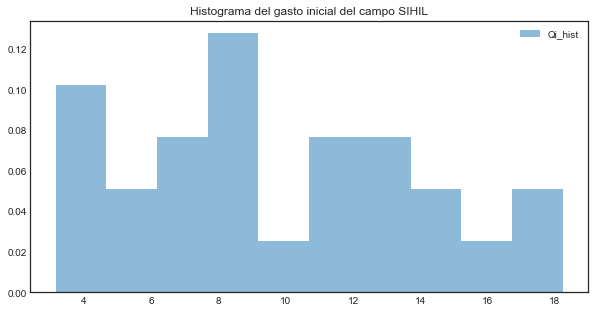

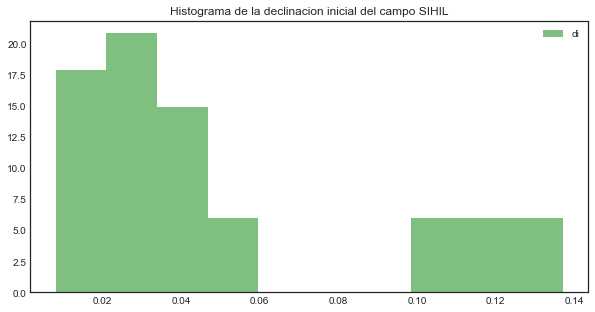

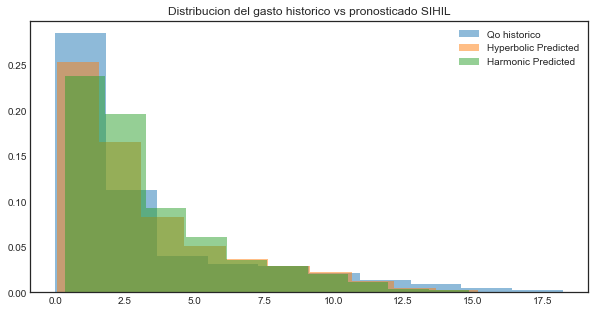

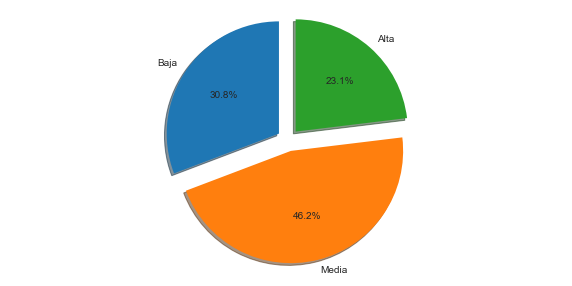

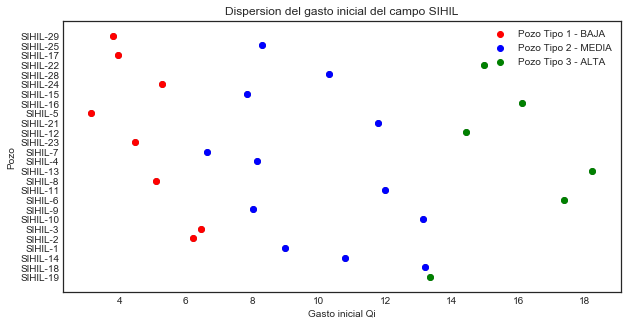

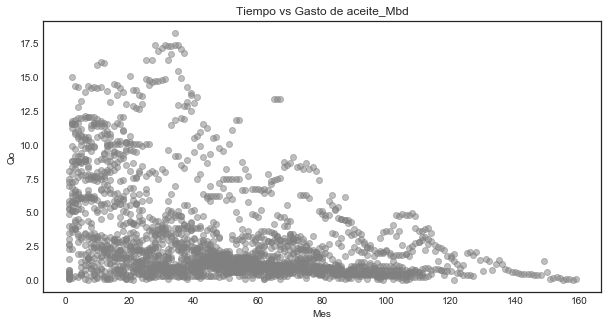

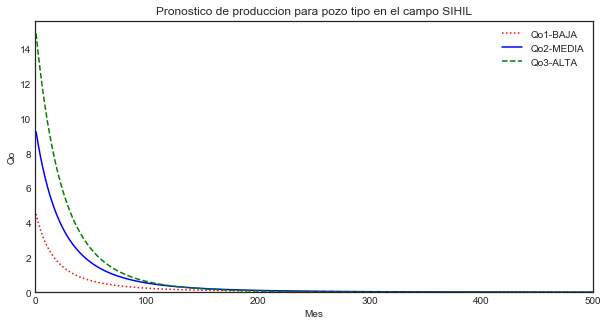

'Tiempo de procesamiento: 913.7839992999999 segundos'

In [5]:
productividad('aceite_Mbd',0.30,0.50,0.80)

Nombre de campo: BENAVIDES


'Número de pozos en BENAVIDES: 128'

'Qi50 del campo:  0.827254'

'Qi50 del Pozo Tipo 1:  0.491406'

'Qi50 del Pozo Tipo 2:  0.931679'

'Qi50 del Pozo Tipo 3:  2.0908875'

'd_media del campo:  0.015096445685142741'

'd_media hyp del Pozo Tipo 1:  0.00816143806036988'

'd_media hyp del Pozo Tipo 2:  0.013817147036861295'

'd_media hyp del Pozo Tipo 3:  0.09101286093661673'

'd_media harm del Pozo Tipo 1:  0.010541205011308414'

'd_media harm del Pozo Tipo 2:  0.01493662572908763'

'd_media harm del Pozo Tipo 3:  0.09388938417165317'

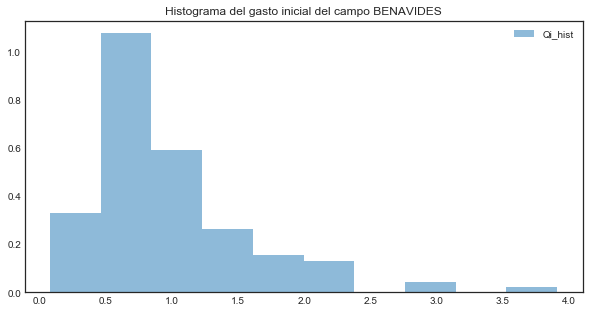

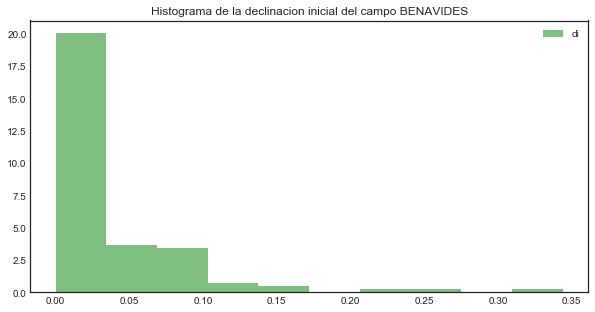

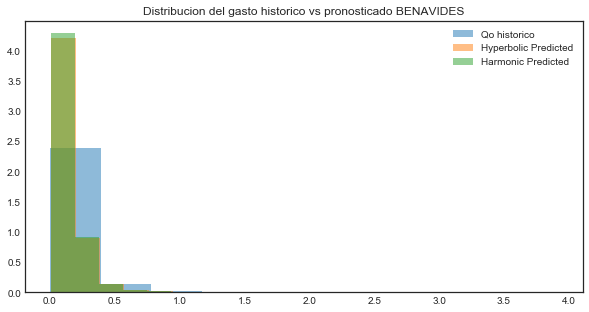

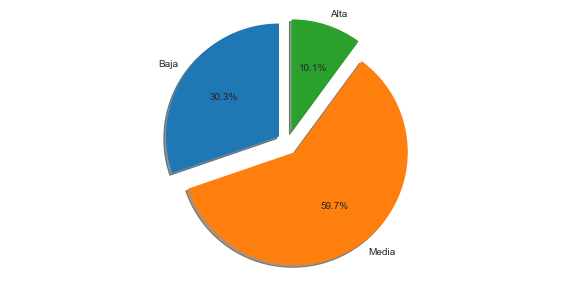

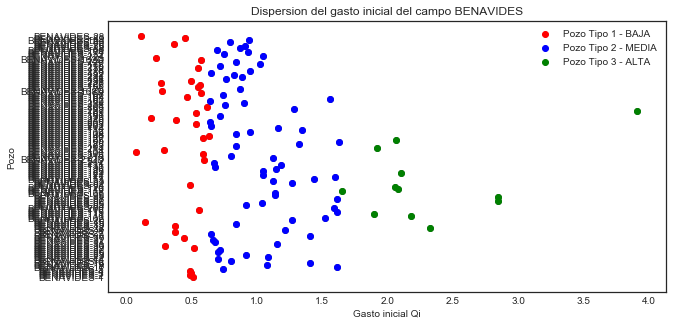

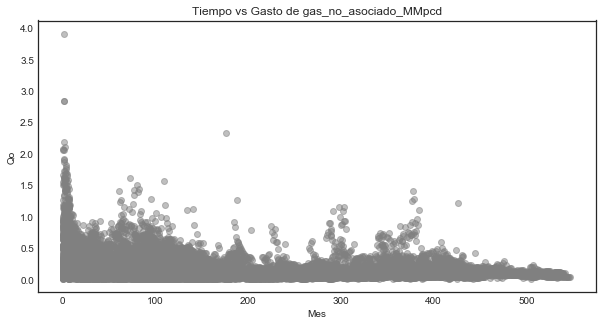

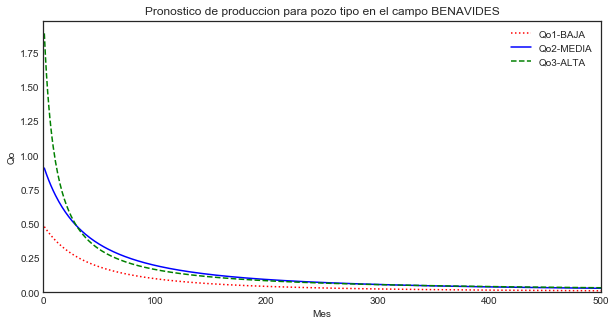

'Tiempo de procesamiento: 74.5568936000002 segundos'

In [6]:
productividad('gas_no_asociado_MMpcd',0.30,0.50,0.90)

In [ ]:
display(Qo)

In [21]:
oil=resultados[['pozo','aceite_Mbd','mes']]

df2=oil.groupby('mes').mean().reset_index()

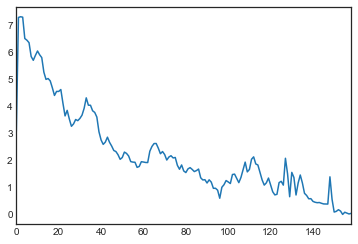

In [22]:
df2.aceite_Mbd.plot()

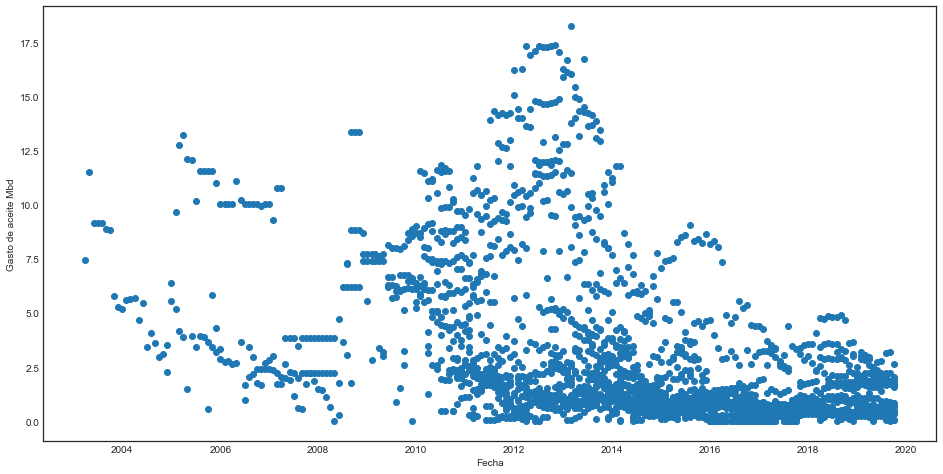

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(campo.fecha,campo.aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()

In [7]:
sns.pairplot(mx_bd)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001BDC981F620> (for post_execute):


KeyboardInterrupt: 

In [17]:
scipy.info(stats)

Statistical functions (:mod:`scipy.stats`)

.. module:: scipy.stats

This module contains a large number of probability distributions as
well as a growing library of statistical functions.

Each univariate distribution is an instance of a subclass of `rv_continuous`
(`rv_discrete` for discrete distributions):

.. autosummary::
   :toctree: generated/

   rv_continuous
   rv_discrete
   rv_histogram

Continuous distributions

.. autosummary::
   :toctree: generated/

   alpha             -- Alpha
   anglit            -- Anglit
   arcsine           -- Arcsine
   argus             -- Argus
   beta              -- Beta
   betaprime         -- Beta Prime
   bradford          -- Bradford
   burr              -- Burr (Type III)
   burr12            -- Burr (Type XII)
   cauchy            -- Cauchy
   chi               -- Chi
   chi2              -- Chi-squared
   cosine            -- Cosine
   crystalball       -- Crystalball
   dgamma            -- Double Gamma
   dweibull          -- Double